## Expressiveness of GNN
The key idea of graph neural networks is aggregating (using neural networks) local network neighborhoods around a given node of interest to generate its embedding, and so to explore how effective this idea is, and in turn how expressive GNNs are, the following question needs to be answered. How well can GNNs distinguish different graph structures (if have different features it is easier to distinguish and thus does not help with the exploration), specifically considering only the local neighborhood structures around each node in a graph (if entire graph is considered, then distinction is trivially done). 

A GNN generates node embeddings through a computational graph defined by the neighborhood and its node features, disregarding the node *ids*; and so structures which differ only in the node *ids* (same computational graph structure and node features) will be considered identical from the perspective of the computational graph.

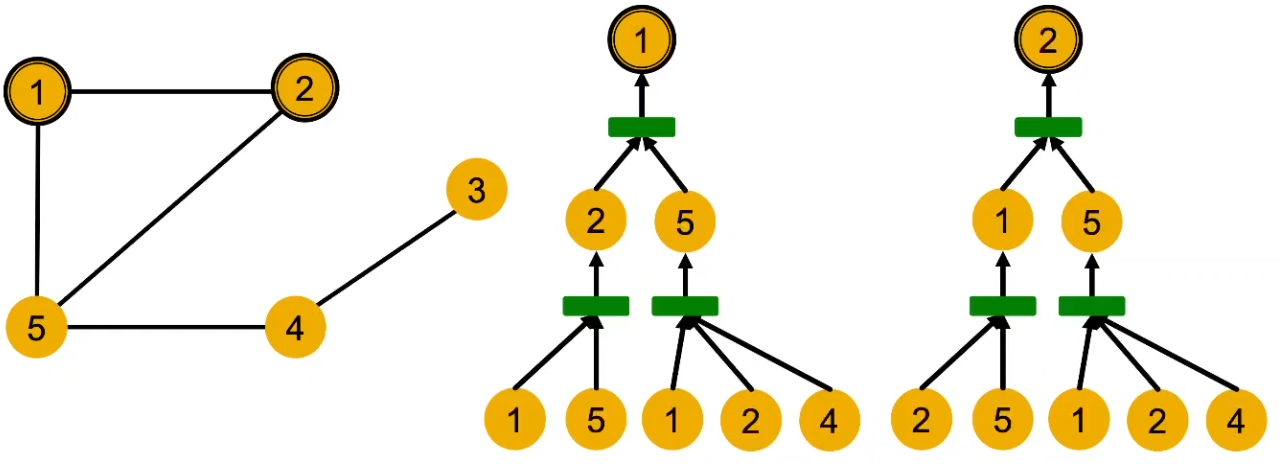

So the most, possible expressive GNN will be able to map different *rooted subtrees* ($k$ layer tree rooted at node of interest with its children beign the parent's neighbors) into differente node embeddings. This means that the most expressive GNN should map subtrees to the node embedding space through an ***injective*** function (maps distinct elements in its domain to distinct elements of its codomain), $f:X\rightarrow Y$, with $f$ intuatively retaining all information about its input.

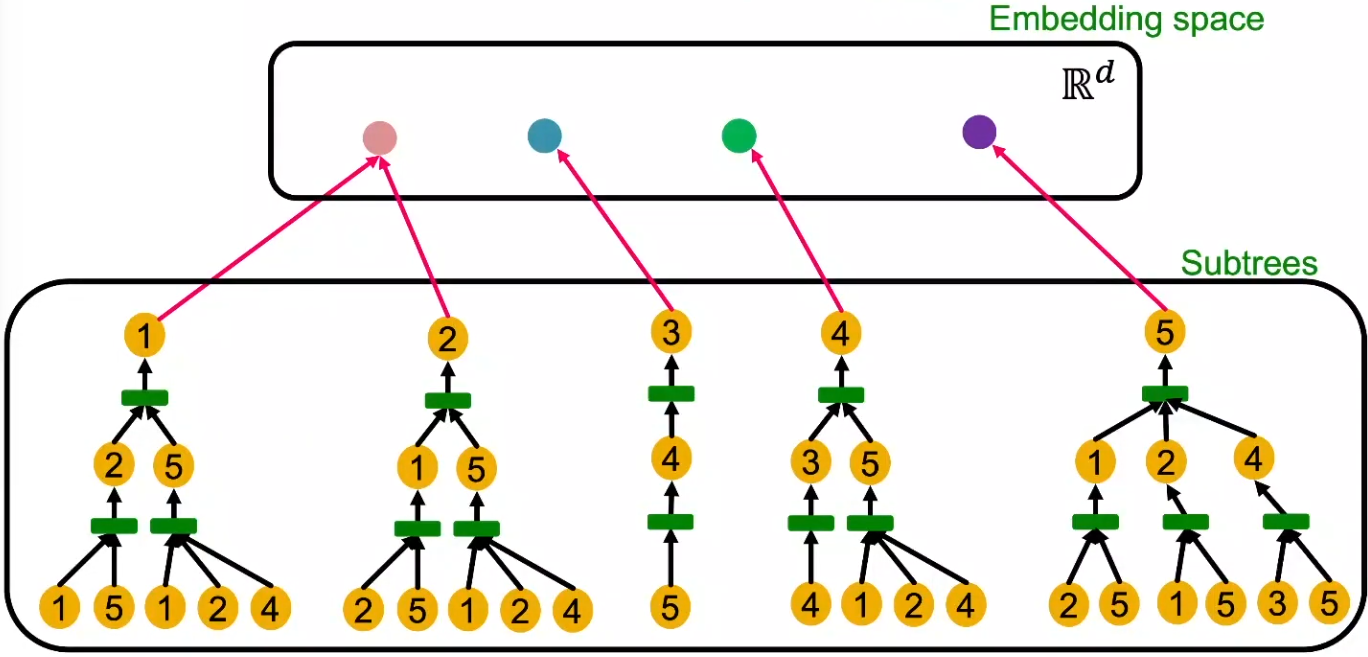

As the subtrees of the same depth can be recursively characterized from the leaf nodes to the root nodes, if each step of a GNN's aggregation (can then be abstracted to a function over a multi-set, a set with repeating elements) is *injective* (fully retain the neighboring information), the generated node embeddings can distinguish different *rooted subtrees*.

GCN uses element-wise mean pooling over neighboring node features to aggregate neighborhoods, $\text{Mean}(\{x_u\}_{u\in N(v)})$ followed by a ReLU function, $\max\{0, x\}$; while GraphSAGE uses element-wise max pooling, $\text{Max}(\{x_u\}_{u\in N(v)})$. This therefore means that GCN's aggregation function cannot distinguish between different multi-sets with the **same color proportions**; while GraphSAGE's cannot distinguish between different multi-sets with the **same set of distinct colors**. It can then be seen that neither GCN or GraphSAGE aggregation functions are injective, and so are not maximally powerful GNNs.

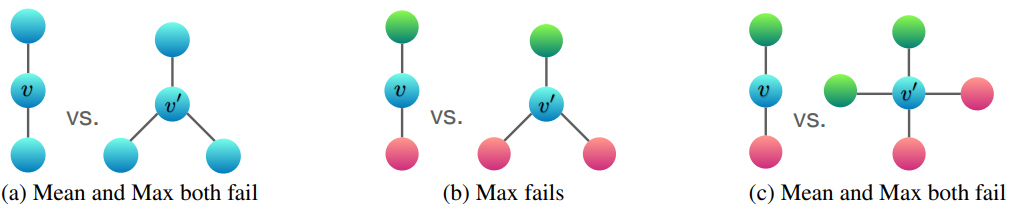

Using the theorem **"any injective multi-set function can be expressed as $\Phi(\sum_{x\in S}f(x))$, where both $\Phi$ and $f$ are non-linear functions"** (can be intuatively seen by $f(x)$ being injective in relations to nodes and seperating the colors enough so when they are summed, a distinct result is entered into $\Phi$ which then does the same on the neighborhood level), an injective neighborhood aggregation function can be designed. Additionally, by the Universal Approximation Theorem; **"a 1-hidden-layer Multi-Layer-Preceptron with sufficiently larger hidden dimensionality and appropriate non-linearity $\sigma(\cdot)$ (including ReLU and sigmoid) can approximate any continuous function to an arbitrary accuracy."**, it means that $\text{MLP}_{\Phi}(\sum_{x\in S}\text{MLP}_{f}(x))$ can model any injective multiset function (In practice, MLP dimensionality of 100-500 is sufficient).

### Graph Isomorphism Netwrok (GIN)
The GNN which uses this injective aggregation function is called *GIN*, and is the most expressive GNN in the class of message-passing GNNs. In essence, *GIN* is the "neural network" version of the *WL graph kernel* (traditional way of obtaining graph-level features); which iteratively refines node colors by re-assigning them $c^{(k+1)}(v)=\text{HASH}(c^{(k)}(v),\{c^{(k)}(u)\}_{u\in N(v)})$, and after $K$ steps of color refinement, each color $c^{(K)}(v)$ summarizes the structure of $v$'s $K$-hop nieghborhood. $\text{HASH}$ functions are as injective as possible as they are precisely defined to minimise collisions; and so it can be $c^{(k+1)}(v)=\text{HASH}(c^{(k)}(v),\{c^{(k)}(u)\}_{u\in N(v)})$ can eb modeled using *GIN* as  $c^{(k+1)}(v)=\text{MLP}_{\Phi}((1+\epsilon)\text{MLP}_{f}(c^{(k)}(v))+\sum_{u\in N(v)}\text{MLP}_{f}(c^{(k)}(u)))$ where $\epsilon$ is a learnable scalar.

It can be additionally seen that if $c^{(0)}(v)$ is represented as one-hot (or similar definitions), direct summation is injective ($(1,0)+(1,0)+(0,1)=(2,1)$, etc.). This means that only $\Phi$ is needed to ensure the injectivity, and thus a simpler *GIN* convolutional layer can be defined as $\text{GINConv}(\{c^{(k)}(v),\{c^{(k)}(u)\}_{u\in N(v)}\})=\text{MLP}((1+\epsilon)c^{(k)}(v)+\sum_{u\in N(v)}c^{(k)}(u))$. And so, given a graph $G$ with a set of $V$ nodes, assigning an initial vector $c^{(0)}(v)$ to each and iteratively updating the vectors by $c^{(k+1)}(v)=\text{GINConv}(\{c^{(k)}(v),\{c^{(k)}(u)\}_{u\in N(v)}\})$; after $K$ steps of *GIN* iterations, $c^{(K)}(v)$ summarizes the structure of $v$'s $K$-hop nieghborhood.

*GIN*'s close relationship with *WL graph kernel* (very powerful model) means that their expressiveness is exactly the same; if two graphs can be distinguished by *GIN*, they can be also distinguished by *WL kernel* and vice versa.

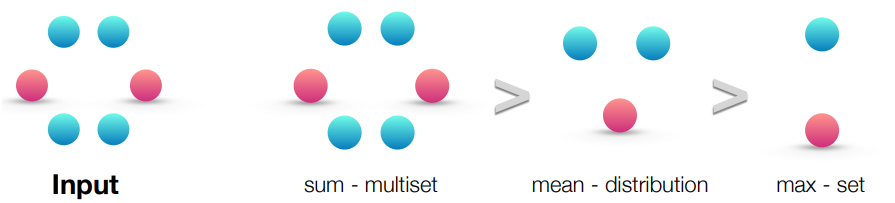

#### Matrix Representation
By simply expanding the *GIN* layer $c^{(k+1)}(v)=\text{MLP}((1+\epsilon)c^{(k)}(v)+\sum_{u\in N(v)}c^{(k)}(u))$ to $\text{MLP}_{-1}(\sigma(W^{(k)}(1+\epsilon)c^{(k)}(v)+\sum_{u\in N(v)}W^{(k)}c^{(k)}(u)))=\text{MLP}_{-1}(\sigma(W^{(k)}_0c^{(k)}(v)+\sum_{u\in N(v)}W^{(k)}_1c^{(k)}(u)))$ where $\text{MLP}_{-1}$ denotes all the MLP layers except the first. Given then that $C^{(k)}\in\mathbb{R}^N\times\mathbb{R}^d$, $C^{(k)}[v,:]=c^{(k)}(v)$, and $A\in\{0,1\}^N\times\{0,1\}^N$ is the adjacency matrix of the graph, the function can be re-written in a matrix form as $$C^{(k+1)}=\text{MLP}_{-1}(\sigma(C^{(k)}W^{(k)}_0+AC^{(k)}W^{(k)}_1))=\text{MLP}_{-1}(\sigma(\sum_{l=0}^{1}A^lC^{(k)}W^{(k)}_l))$$


Given a real, symmetric, matrix ($\bar{A}^{\text{T}}=A$) $A$. Its eigenvalues are real (given $Ax=\lambda x$, $A\bar{x}=\bar{\lambda}\bar{x}\rightarrow\bar{x}^{\text{T}}A=\bar{x}^{\text{T}}\bar{\lambda}$ and so both $\bar{x}^{\text{T}}Ax=\bar{x}^{\text{T}}\lambda x$ and $\bar{x}^{\text{T}}Ax=\bar{x}^{\text{T}}\bar{\lambda}x$ meaning that $\lambda=\bar{\lambda}$ and so is real) and the corresponding eigenvectors can be chosen as orthogonal:
- If $\lambda$s are distinct, their corresponding $q_{(i)}$ are orthogonal. Let $Ax=\lambda x$ and $Ay=\mu y$ such that $\lambda \neq \mu$, then $\lambda x \cdot y=Ax\cdot y = x^{\text{T}}A^{\text{T}}y=x\cdot Ay = x\cdot \mu y \rightarrow (\lambda - \mu)x\cdot y = 0$  and so $x$ is orthogonal to $y$.
- If $\lambda$ repeats, there's a plane of corresponding $q_{(i)}$ and can so be chosen such that they are orthogonal (Gram-Schmidt Process).

$$Aq_{(i)}=\lambda_{(i)} q_{(i)}\rightarrow AQ=Q\Lambda\rightarrow A=Q\Lambda Q^{-1}$$
$$\therefore A^k=Q\Lambda^k Q^{-1}$$

Additionally, $A=Q\Lambda Q^{-1}\rightarrow A^{\text{T}}={Q^{-1}}^{\text{T}}\Lambda^{\text{T}} Q^{\text{T}}$; and as $\Lambda$ and $A$ are symmetric, $A={Q^{\text{T}}}^{-1}\Lambda Q^{\text{T}}$ and so $Q\Lambda Q^{-1}={Q^{\text{T}}}^{-1}\Lambda Q^{\text{T}}$ which is only possible if $Q^{-1}=Q^{\text{T}}$. Therefore, $A=Q\Lambda Q^{\text{T}}=\sum_{i=1}^{n}\lambda_{(i)}q_{(i)}q^{\text{T}}_{(i)}$ such that $\lambda_{(1)}\geq\ldots\geq\lambda_{(n)}$ and $\text{Eig}_{\lambda_{(i)}}(A)=q_{(i)}$


The eigenvalue (spectral) decomposition of the adjacency matrix is a universal characterization of the graph; where different graphs have different spectral decompositions. Additionally, the number of cycles in a graph can be viewed as a function of eigenvalues and eigenvectors ($\text{\#triangles}=\text{diag}(A^3)=\sum_{n=1}^N\lambda_n^3|q_n|^2$). This meanst that *GIN* layers can be interpreted as MLPs operating on eigenvectors if $A$ is replaced with $A=Q\Lambda Q^{\text{T}}$:
$$C^{(k+1)}=\text{MLP}_{-1}(\sigma(\sum_{l=0}^{1}(Q\Lambda Q^{\text{T}})^lC^{(k)}W^{(k)}_l))=\text{MLP}_{-1}(\sigma(Q\mathbb{W}))$$
$$\mathbb{W}[n,f]=\sum_{i=1}^d\sum_{l=0}^1\lambda_{(n)}^lW_l[i,f](q_{(n)}^{\text{T}}C^{(k)}[:,i])$$
And so it can be seen that the weights of the first MLP layer depend on the eigenvalues and the dot product between the eigenvectors and the coloers at the previous level. As initially all nodes begin with color $1$ (otherwise cannot maintain consistency of process across different graphs, etc.) and so $\mathbb{W}[n,f]=\sum_{i=1}^d\sum_{l=0}^1\lambda_{(n)}^lW_l[i,f](q_{(n)}^{\text{T}}1)$ and so the new node colors only depend on the eigenvectors that are not orthogonal to $1$ (else will be $0$). 

As stated above, matrix decomposition obtains eigenvectors as being orthogonal to each other and further, graphs with symmetries admit eigenvectors orthogonal to 1; meaning that critical spectral components are ommitted in the message-passing operations due to them being orthogonal to the initial node color (limiting factor), causing limitted representations, constant node colorings, and the inability to distinguish between some graph structures, or count basic graph structures.

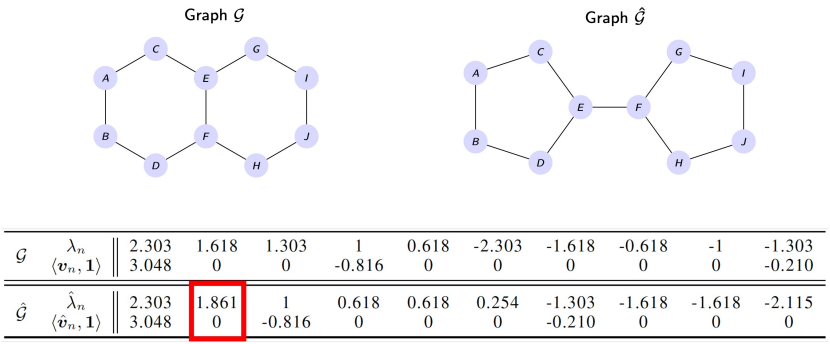

This specific limitation applies to *WL graph kernel* (and *GIN* which emulates it); however, consider the GNN model where each layer is defined as $c^{(k+1)}(v)=\text{Linear}((1+\epsilon)c^{(k)}(v)+\sum_{u\in N(v)}c^{(k)}(u))$ and the last layer has the non-linear function, $\sigma(\cdot)=(\cdot)^2$ (square pointwise nonlinearity function), apply $c^{(K)}(v)=\sigma(c^{(K)}(v))$; if then it is applied onto nodes whose colors are represented injectively, it realises the injective theorem (as stated above) and therefore is a *GIN* layer. Representing node ids as random samples will cause the *GIN* model to produce different results $y^{(1)},y^{(2)},\ldots,y^{(n)}\overset{\text{iid}}{\sim}Y$ every runs (new samples), and though each result is independent and identically distributed; the underlying distribution has the graph's structural information, and so the final result can be a statistic of it $$y=\mathbb{E}[y^{(m)}]\rightarrow y=\frac{1}{M}\sum_{m=1}^{M}y^{(m)}$$
It can be seen that the previous procedure computes the closed loops of a graph $C^{(0)}=[\text{diag}(A^{0}),\text{diag}(A^{1}),\text{diag}(A^{2}),\ldots,\text{diag}(A^{D-1})]\in\mathbb{N}_0^N\times\mathbb{N}_0^D$ and thus it can break the limitations of the *WL graph kernel* and count importatn substructures in the graph.

### Position Aware Tasks
Upto now, all tasks investigated so far were **"structure aware"** tasks; where a GNN constructs different computation graphs for nodes which are structurally different from each other (assuming most difficult situation where all nodes have the same feature). However **"position aware"** tasks; where different nodes in different positions on the graph have identical computation graphs will always cause GNN to fail, as tehre is no distinguishing features between them. It is possible however to define deep learnign methods that are position ware.

<table><tr><td>

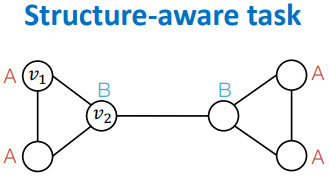
</td><td>

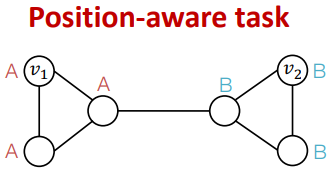
</td></tr></table>

#### ***Anchor***
A simple method can be logically defined by randomly picking a node $s_1$ as an *anchor node*, with all all other nodes being defined via their relative distance with relations to the *anchor*; thereby serving as a coordinate axis (can be used to locate nodes in the graph). It can also be observed that more *anchors* can better characterize node positions in different regions (increase coordinate axes).

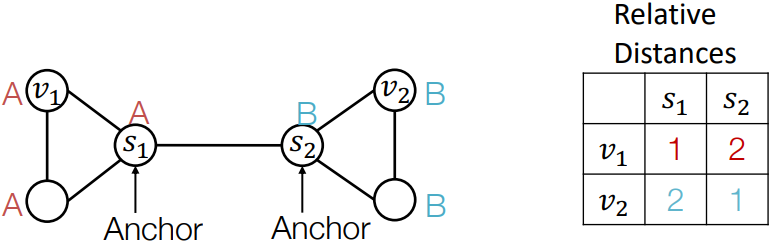

This can then be generalized into defining not only one node as and *anchor* but also sets of nodes as an *anchor set*; where the distance to an *anchor set* is the minimum distance to all the nodes in the set.

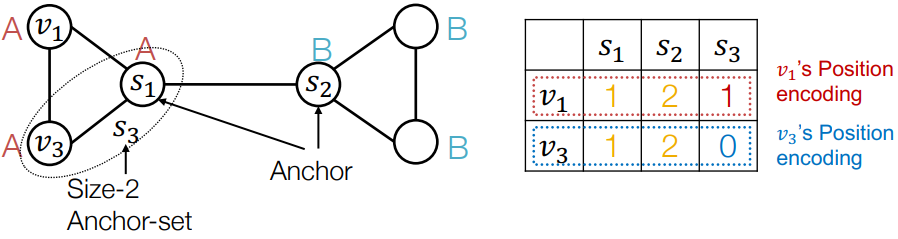

What this does in essence is to embed teh metric space $(V,d)$ into the euclidian space $\mathbb{R}^k$ such that the original distance metric is preserved; for every node pairs $u,v\in V$, teh euclidian embedding distance $||z_u-z_v||_2$ is close to the original distance metric $d(u,v)$. A rigorous definition is provided by the **Bourgain Theorem** for an embedding function which produces embeddings which are provably close to the original distance metric: $$f(v)=(d_{\min}(v,S_{1,1}),d_{\min}(v,S_{1,2}),\ldots,d_{\min}(v,S_{\log n,c\log n}))\in\mathbb{R}^{c\log^2n}$$where $c$ is a constant, $S_{i,j}\subset V$ is chosen by including each node in $V$ independently with probability $\frac{1}{2^i}$ and $d_{\min}(v,S_{i,j})\equiv \min_{u\in S_{i,j}}d(u,v)$.

This definition is used in the *P-GNN* model, which first samples $O(\log^2n)$ *anchor* sets $S_{i,j}$ and embed each node $v$ as $(d_{\min}(v,S_{1,1}),d_{\min}(v,S_{1,2}),\ldots,d_{\min}(v,S_{\log n,c\log n}))\in\mathbb{R}^{c\log^2n}$. During training, new *anchor sets* are re-sampled every time to ensure *P-GNN* maintains teh inductive capability and learns to operate over unseen sets (will be done at test time).

While the simplest way to use this position aware encoding is to use it as an augmented node feature (works well in practice), since each dimension of position encoding is tied to a random *anchor set*, dimensions of positional encoding can be randomly permuted without changing its meaning. It therefore, requires a special nueral network, for a rigorous solution, that can maintain the permutation invariant property of position encoding (permutation of input feature dimension will only result in the permutation of the output dimension). More information in https://arxiv.org/pdf/1906.04817.

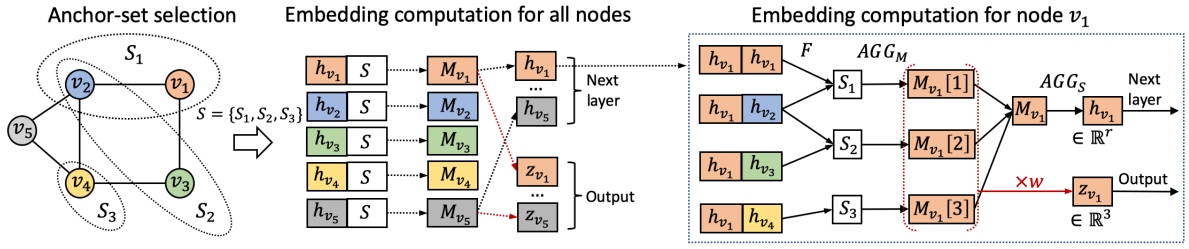